# Real-Time Stop Sign Identification using Contour Detection
### Olivia Roberts, Anne Konicki, William Grieder

# Image Preprocessing

In [58]:
#imports

import cv2
import numpy as np
from typing import List, Any

In [59]:
def display_image_and_wait(name: str, img) -> None:
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def display_images_and_wait(names: List[str], images: List[Any]) -> None:
    assert len(images) == len(names), "You must provide the same number of images and names"

    for name, img in zip(names, images):
        cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [60]:
# Convert image to HSV
img_bgr = cv2.imread('./assets/StopSign01.jpg')
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

#display_images_and_wait(['Original', 'HSV'], [bgr_img, hsv_img])

In [61]:
# Binarize Image

# Best threshold appears to be 192. More testing needed

image_grayscale = cv2.cvtColor(img_hsv, cv2.COLOR_BGR2GRAY)
#display_image_and_wait('Black and White', gray_img)

_, binarized_img = cv2.threshold(image_grayscale, 127, 255, cv2.THRESH_BINARY) # Store the 192 threshold version of the image for later use
#('Binarized', bin_img)

In [62]:
# Apply Gaussian Blur

# Analyze the images to see if the stop sign's become more visually distinct on the image.
# Use different threshold values as well. StopSign2 will be a useful image for this as part of the sign is obscured.
# See if applying the blur can potentially remove the graffiti affect. it may also be useful to apply the blur to detect ellipses rather than octagons.
# Blurring the image could make contour detection easier

# This ended up not being needed/useful, but the ability to do it is still here

blur_img = cv2.blur(binarized_img, (3, 3))
#display_image_and_wait('Blurred', blur_img)

## Contour Detection

In [63]:
# Detect Octagons

copy_image = img_bgr.copy()

all_contours, _ = cv2.findContours(binarized_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)



def test_hexagon(contour: Any) -> bool:
    # Approximate the contour to a polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # If it doesn't have 8 sides, it isn't an octagon
    if len(approx) != 8:
        return False

    # Calculate all side lengths
    side_lengths = [
        np.linalg.norm(approx[i][0] - approx[(i + 1) % 8][0])
        for i in range(8)
    ]
    mean_length = np.mean(side_lengths)

    # Check if side lengths are approximately equal
    # Uses 0.2 as tolerance for images at odd angles
    return all(abs(length - mean_length) <= 0.2 * mean_length for length in side_lengths)


hex_contours = [contour for contour in all_contours if test_hexagon(contour)]

# Uncomment lines to see raw contours being drawn

#cv2.drawContours(image=img_copy, contours=hexagon_contours, contourIdx=-1, color=(0, 255, 255), thickness=2)
#display_image_and_wait('Found Octagon Contour', img_copy)

In [64]:
# Bounding Box
for hex in hex_contours:
    rect = cv2.boundingRect(hex)
    if rect[2] < 100 or rect[3] < 100: continue
    x,y,w,h = rect
    cv2.rectangle(copy_image,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(img=copy_image,text='Stop Sign',org=(x,y-20),fontFace=0,
                fontScale=0.8,color=(0,0,0), thickness=2)
display_image_and_wait('Found Stop Signs', copy_image)

cv2.imwrite("./FoundSign.png", copy_image)

True

# Contour Detection Automated Testing

In [65]:
# Function below performs all steps as above as one function, rather than with seperated steps and displaying images during the step-by-step process

def detect_stop_sign(img_location: str) -> bool:
    """
    :param img_location: local location of the image to attempt to detect stop sign in
    :return: True if stop sign is detected, False otherwise
    """
    try:
        bgr_img = cv2.imread(img_location)
        gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

        _, bin_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)

        img_copy = bgr_img.copy()

        contours, _ = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        hexagon_contours = [contour for contour in contours if test_hexagon(contour)]

        return_value = False

        # Bounding Box
        for hexagon in hexagon_contours:
            rect = cv2.boundingRect(hexagon)
            if rect[2] < 100 or rect[3] < 100: continue
            x,y,w,h = rect
            cv2.rectangle(img_copy,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(img=img_copy,text='Stop Sign',org=(x,y-20),fontFace=0,
                        fontScale=0.8,color=(0,0,0), thickness=2)
            # A bounding box was drawn around a supposed hexagon, therefore we are true
            return_value = True

        # display_image_and_wait('Found Stop Sign', img_copy)

        cv2.imwrite(f".assets/output/{img_location}.png", img_copy)
        return return_value
    # Should this fail for whatever reason, well. We didn't find a stop sign!
    except:
        return False

In [66]:
# get all test image files

import glob
import pandas as pd

image_files = []

for filename in glob.glob("./assets/test/*"):
    if filename.endswith(".jpg"):
        image_files.append(filename)

data = {
    'image_id': [],
    'image_path': [],
    'stop_sign_found': [],
}

csv_file_path = './output/ContourOutput.csv'

# for manually testing only the head of the data
# image_files = image_files[:5]

for index, filename in enumerate(image_files):
    data['image_id'].append(index)
    data['image_path'].append(filename)
    data['stop_sign_found'].append(detect_stop_sign(filename))

df = pd.DataFrame(data)
# Output data to a CSV
df.to_csv(csv_file_path, index=False)
df


,image_id,image_path,stop_sign_found
0,0,./assets/test\1000_F_178925847_Y9XCgnGQsOrvGGS...,False
1,1,./assets/test\100_s_jpg.rf.64ea390075b5420ae40...,False
2,2,./assets/test\11121burnslakeVandalism_jpg.rf.4...,False
3,3,./assets/test\119-JPG_0000_0426_0130_0226_0240...,True
4,4,./assets/test\121484920_52a2152b99_z_jpg.rf.23...,False
...,...,...,...
60,60,./assets/test\vandalized_signs_bolinas_jpg.rf....,False
61,61,./assets/test\Vandalized_stop_sign_-_start_and...,False
62,62,./assets/test\Washington_Storm_91335-jpg-96c4c...,False
63,63,./assets/test\w_png.rf.68a047f139a1ccb3e93c50b...,False


# Automation analysis

<Axes: xlabel='Stop Sign Found?', ylabel='Count'>

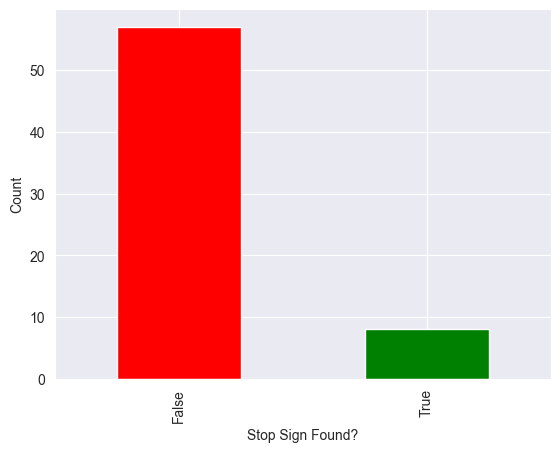

In [73]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

counts = df['stop_sign_found'].value_counts()
counts.plot(kind='bar',
            xlabel='Stop Sign Found?',
            ylabel='Count',
            color=['red', "green"])

In [69]:
print(counts)

stop_sign_found
False    57
True      8
Name: count, dtype: int64


# YOLO v5
